## GEOSeMOSYS - exploring linear programming geospatial energy modelling 

Nandi Moksnes, Mark Howells, ...

This Jupyter Notebook is dectription of how to reproduce the results in the paper:
For any questions please contact Nandi Moksnes: nandi@kth.se

## 1. The files in "GIS_data" are downloaded and placed in a "temp" folder.

In [1]:
from Download_files import *
import os
current = os.getcwd()
os.chdir(current)
print(os.getcwd())

download_url_data('input_data/GIS_URL.txt', 'temp')
unzip_all('input_data/GIS_URL.txt')

C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\src


()

## 2. The files are then projected and clipped to the administrative boundaries.

In [2]:
from Project_GIS import *
os.chdir(current)

main('../GIS_data')

C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\11kVtransmissionKenya\Transmission lines 11kV\11kV.shp
C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\132kVtransmissionKenya\Transmission lines 132kV\132kV.shp
C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\220kVtransmissionKenya\Transmission lines 220kV\220kV.shp
C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\33kVtransmissionKenya\Transmission lines 33kV\33kV.shp
C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\66kVtransmissionKenya\Transmission lines 66kV\Transmission_66kV.shp
C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\GIS_data\gadm36_KEN_shp\gadm36_KEN_0.shp
C:

()

## 3. Through QGIS make raster to point layer and save

1) masked_UMT37S_ken_ppp_2018_1km_Aggregated: SAGA raster to point 

This step is downloaded from zenodo so it is not needed for the user to execute.


In [1]:
from Download_files import *
import os
current = os.getcwd()
os.chdir(current)
print(os.getcwd())
download_url_data('input_data/zenodo.txt', '/Projected_files')

C:\Users\nandi\Box Sync\PhD\Paper 3-OSeMOSYS 40x40\GIS_python_build\GEOSeMOSYS_reprod\GEOSeMOSYS_Kenya\src


()

## 4. The GIS layers are prepared to for a heuristic approximation for electrified settlements

In [13]:
import matplotlib.pyplot as plt
from settlement_build import *
current = os.getcwd()
os.chdir(current)

pop_shp = '../Projected_files/raster_to_point_UMT37S_Kenya.shp'
Projected_files_path = '../Projected_files'

rasterize = raster_proximity(Projected_files_path)
points = raster_to_point(rasterize, pop_shp, Projected_files_path)

points.sample

epsg:32737
EPSG:32737
Nighttime light
epsg:32737
Distance to substations
epsg:32737


KeyboardInterrupt: 

## 5. Approximate location of urban settlements and the electrified settlements 1kmx1km resolution

Calibrate current population
Calibrate urban split
Calibrate current electrification
The modelled electrification rate achieved is 0.7401061239182143. If this is not acceptable please revise this part of the algorithm
nightlight: 0.29301766745706603 Transformers: 5000 Grid: 60 Road 5 Elec: 0.7401061239182143 pop_threshold: 2906.1349875519186 36000 Rural_ele: 1 1


AttributeError: 'Line2D' object has no property 'column'

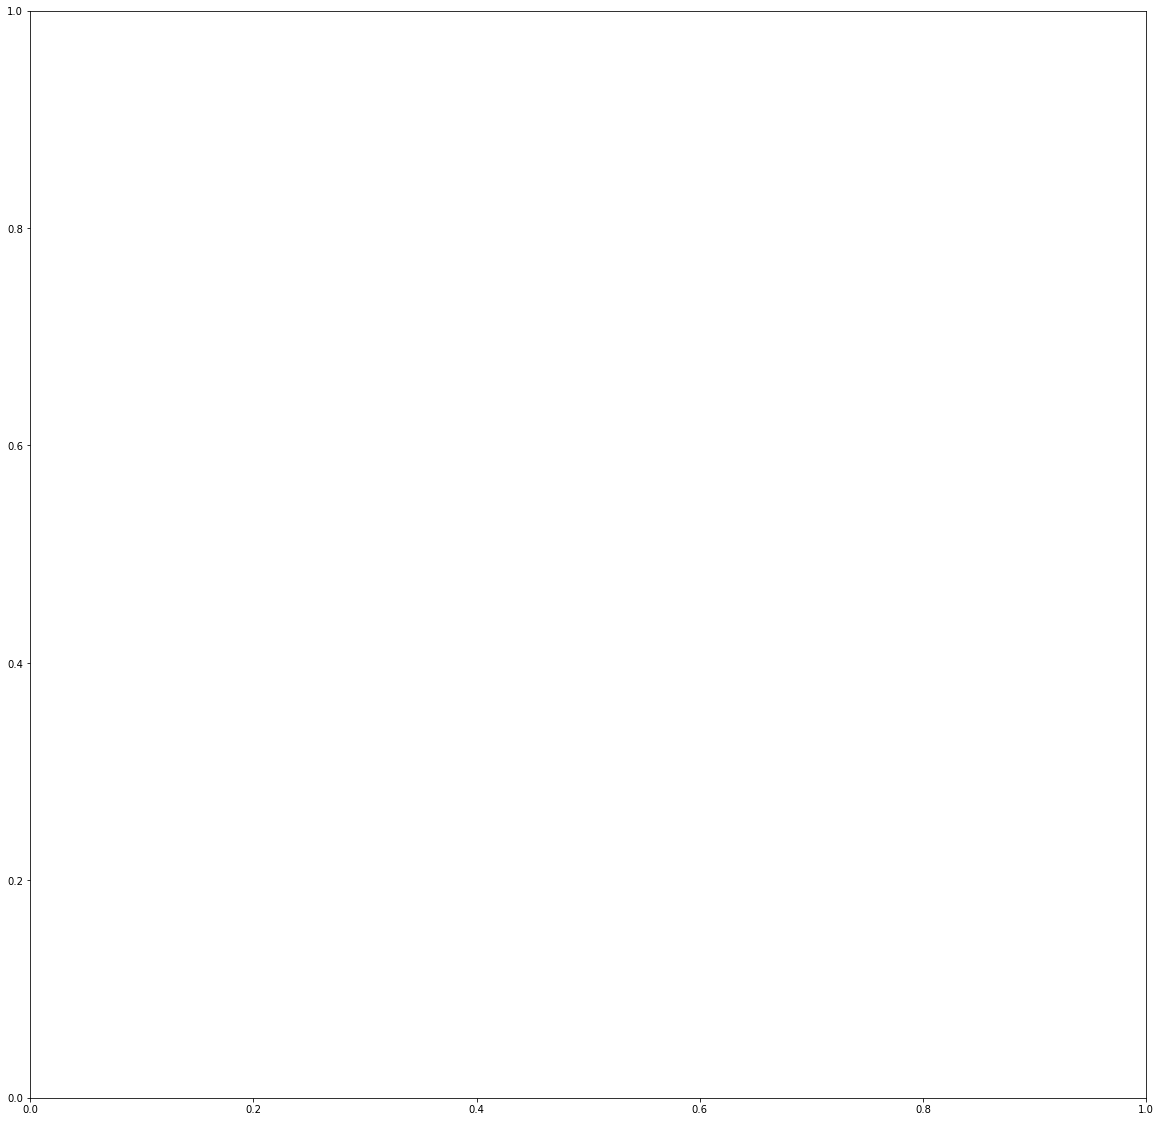

In [1]:
from elec_start import *
import os
current = os.getcwd()
os.chdir(current)

elec_actual = 0.75  # percent
pop_cutoff = 4000  # people
dist_minigrid = 5000  # meters
dist_to_trans = 5000  # meters
dist_to_sub = 5000 #meters
dist_minig = 5000 #meters
min_night_lights = 20
max_grid_dist = 20000  # meters
max_road_dist = 300  # meters
pop_cutoff2 = 36000 # people
urban_elec_ratio = 83.5  # percent
rural_elec_ratio = 71.5  # percent
pop_actual = 52570000  # peolpe
urban = 0.275  # percent
urban_cutoff = 20000
start_year = 2018
settlement = gpd.read_file("../Projected_files/settlements.shp")

settlements = pd.DataFrame(settlement, copy=True)
urbansettlements = calibrate_pop_and_urban(settlements, pop_actual, urban, urban_cutoff)
elec_current_and_future(urbansettlements, elec_actual, pop_cutoff, dist_to_trans, dist_to_sub, dist_minig, min_night_lights,
                            max_grid_dist, urban_elec_ratio, rural_elec_ratio, max_road_dist, pop_actual, pop_cutoff2, start_year)

%matplotlib inline
settlements.plot(column='elec', cmap=None, legend=True, figsize=(20, 20))

## 6. Download Renewable.ninja data for all 378 locations

In [2]:
from renewable_ninja_download import *

shapefile = '../Projected_files/new_40x40points_WGSUMT37S.shp'
path = "temp"
coordinates = project_vector(shapefile)
wind, solar = csv_make(coordinates)
down = download(path, wind, solar)



../Projected_files/new_40x40points_WGSUMT37S.shp
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets
Waiting to download next 50 data sets


IndexError: list index out of range

## 7. Scale down from1x1 km to 40 x 40 km demand cells